In [1]:
%load_ext autoreload
%autoreload 2

from dataloader import SignalDataloader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import lightning.pytorch as pl
import yaml
from tqdm import tqdm
from ml4gw.transforms import SpectralDensity, Whiten

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

/home/eric.moreno/gwak2/gwak/data/prior.py:5: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
data_dir = "/home/katya.govorkova/gwak2_background/"
sample_rate = 2048
kernel_length = 0.5
psd_length = 64
fduration = 1
fftlength = 2
batch_size = 512
batches_per_epoch = 10
num_workers = 2
data_saving_file = None
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background"
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC(),
    None
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    ),
    None
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None,
    None
]

In [4]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    data_saving_file=data_saving_file
)
test_loader = loader.test_dataloader()

['background-1403754093-2079.h5', 'background-1403135796-674.h5', 'background-1403140125-6720.h5', 'background-1403907950-16.h5', 'background-1403249920-3267.h5', 'background-1402280002-29947.h5', 'background-1403118009-9376.h5', 'background-1403647395-18183.h5', 'background-1403027575-9210.h5', 'background-1403075218-40998.h5', 'background-1403039837-14420.h5', 'background-1402085981-267.h5', 'background-1403388029-1315.h5', 'background-1402402667-17432.h5', 'background-1403219603-7156.h5', 'background-1402511378-42.h5', 'background-1403218496-10.h5', 'background-1403556520-3441.h5', 'background-1402351626-6004.h5', 'background-1403457300-7138.h5', 'background-1403766089-24271.h5', 'background-1403389354-12472.h5', 'background-1403677775-3132.h5', 'background-1402396067-4066.h5', 'background-1402722547-1518.h5', 'background-1402428544-5911.h5', 'background-1402046551-23281.h5', 'background-1402538217-277.h5', 'background-1403625707-3281.h5', 'background-1403732091-8574.h5', 'backgroun

In [5]:
for batch in test_loader:
    [batch] = batch
    print(batch)
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    x = loader.multiInject(waveforms, batch)
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)])
    break

tensor([[[-7.7585e-18, -7.7720e-18, -7.7707e-18,  ...,  5.8071e-18,
           5.7745e-18,  5.7915e-18],
         [-6.1332e-19, -6.2807e-19, -6.4461e-19,  ..., -2.7838e-18,
          -2.8160e-18, -2.8222e-18]],

        [[-6.3109e-18, -6.3313e-18, -6.3130e-18,  ..., -2.8045e-18,
          -2.7989e-18, -2.8050e-18],
         [ 1.2144e-17,  1.2144e-17,  1.2145e-17,  ..., -1.4389e-18,
          -1.4600e-18, -1.4768e-18]],

        [[-1.2146e-18, -1.2472e-18, -1.1863e-18,  ...,  5.0522e-18,
           5.0506e-18,  5.1020e-18],
         [-1.2227e-17, -1.2197e-17, -1.2190e-17,  ..., -5.1309e-18,
          -5.1391e-18, -5.1259e-18]],

        ...,

        [[ 2.8303e-18,  2.8183e-18,  2.8224e-18,  ...,  3.9946e-18,
           3.9951e-18,  4.0010e-18],
         [ 1.5236e-18,  1.5045e-18,  1.5098e-18,  ...,  3.3409e-18,
           3.3556e-18,  3.3514e-18]],

        [[-4.1143e-18, -4.1078e-18, -4.1186e-18,  ...,  3.4356e-19,
           3.4255e-19,  3.0561e-19],
         [-3.2858e-18, -3.2749e-1

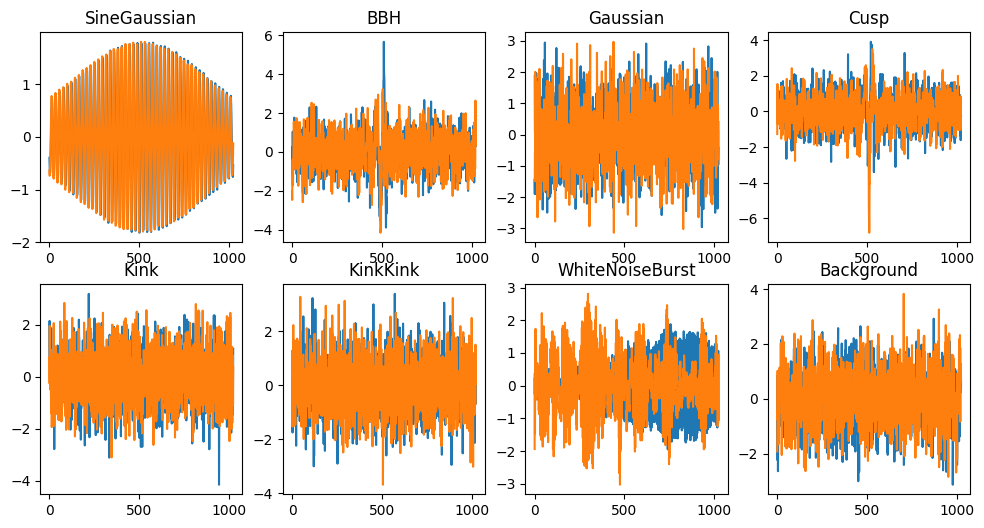

In [6]:
fig,axes = plt.subplots(2,4,figsize=(12,6))

for i, c in enumerate(signal_classes):
    plt.sca(axes[i//4,i%4])
    for k in range(1,2):
        xsel = x[labels==i+1][k,0,:]
        n = np.arange(len(xsel))
        plt.plot(n,xsel.cpu().numpy())
        xsel = x[labels==i+1][k,1,:]
        plt.plot(n,xsel.cpu().numpy())
    plt.title(c)

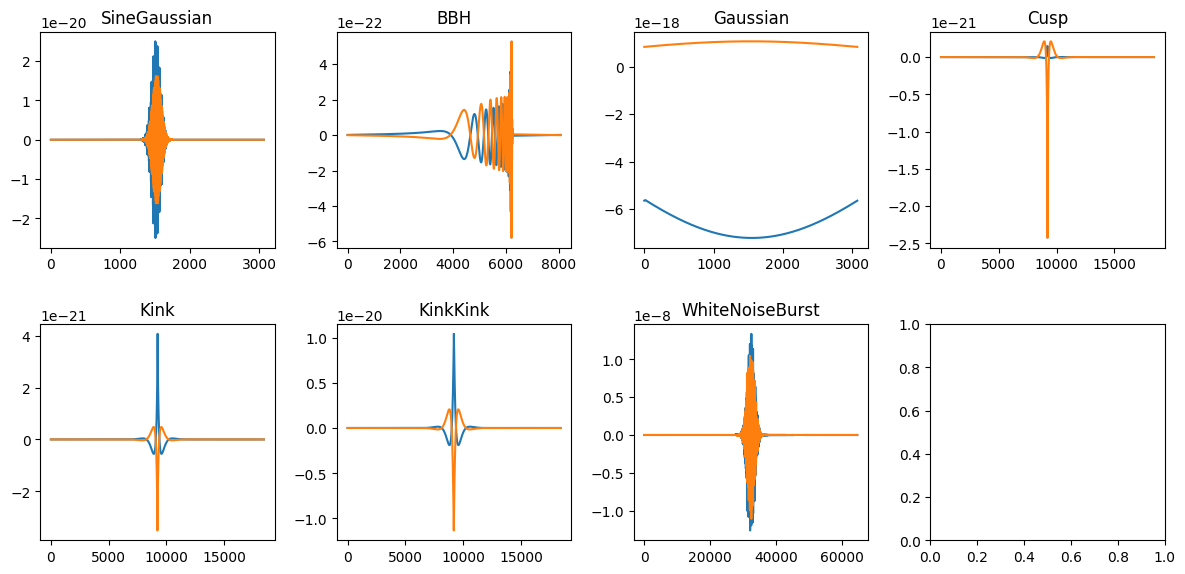

In [7]:
fig,axes = plt.subplots(2,4,figsize=(12,6))

for i, c in enumerate(signal_classes):
    plt.sca(axes[i//4,i%4])
    if waveforms[i] is None:
        continue
    xsel = waveforms[i][0,0,:]
    n = np.arange(len(xsel))
    plt.plot(n,xsel.cpu().numpy())
    xsel = waveforms[i][0,1,:]
    plt.plot(n,xsel.cpu().numpy())
    plt.title(c)
plt.tight_layout()

In [8]:
def plot(i,hp=None):

    b = batch[:1].clone()
    w = waveforms[i][:1].clone()

    split_size = int((kernel_length + fduration) * sample_rate)
    splits = [b.size(-1) - split_size, split_size]
    psd_data, bt = torch.split(b.clone(), splits, dim=-1)

    spectral_density = SpectralDensity(
        sample_rate,
        fftlength,
        average = 'median'
    )
    spectral_density = spectral_density.to('cuda') if torch.cuda.is_available() else spectral_density

    psds = spectral_density(psd_data.double())

    inj_len = w.shape[-1]
    window_len = splits[1]
    half = int((window_len - inj_len)/2)

    first_half, second_half = half, window_len - half - inj_len
    wf = F.pad(
        input=w,
        pad=(first_half, second_half),
        mode='constant',
        value=0
    )

    summed = bt + wf

    whitener = Whiten(
                fduration,
                sample_rate,
                highpass = hp,
            )
    whitener = whitener.to('cuda') if torch.cuda.is_available() else whitener

    whitened = whitener(summed.double(), psds.double())

    # normalize the input data
    stds = torch.std(whitened, dim=-1, keepdim=True)
    whitened = whitened / stds


    fig,axes = plt.subplots(1,4,figsize=(20,4))
    n = np.arange(wf.shape[-1])

    plt.sca(axes[0])
    plt.plot(n,wf[0,0,:].cpu().numpy())
    plt.plot(n,wf[0,1,:].cpu().numpy())
    plt.title('waveform')

    plt.sca(axes[1])
    plt.plot(n,bt[0,0,:].cpu().numpy())
    plt.plot(n,bt[0,1,:].cpu().numpy())
    plt.title('bkg')


    plt.sca(axes[2])
    plt.plot(n,summed[0,0,:].cpu().numpy())
    plt.plot(n,summed[0,1,:].cpu().numpy())
    plt.title('sum')

    plt.sca(axes[3])
    n2 = np.arange(whitened.size(-1))
    plt.plot(n2,whitened[0,0,:].cpu().numpy())
    plt.plot(n2,whitened[0,1,:].cpu().numpy())
    plt.title('whitened')

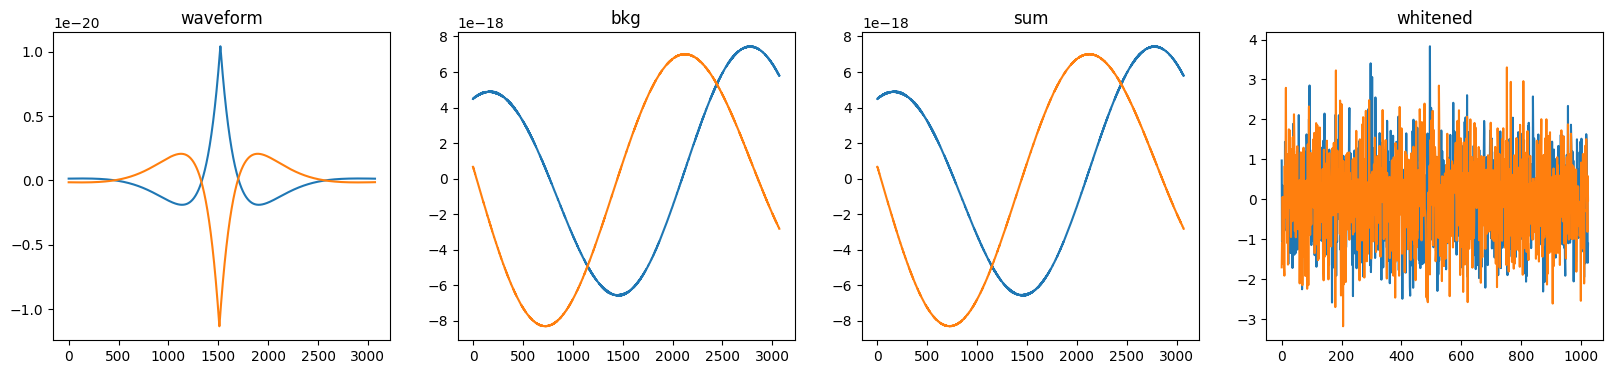

In [9]:
plot(5,hp=30)

In [10]:
from models import Crayon
import yaml

ckpt = "../output/test_S4_fixedSignals_0p5sec_v2/lightning_logs/2wla29uz/checkpoints/33-1700.ckpt"
cfg_path = "../output/test_S4_fixedSignals_0p5sec_v2/config.yaml"
with open(cfg_path,"r") as fin:
    cfg = yaml.load(fin,yaml.FullLoader)

model = Crayon.load_from_checkpoint(ckpt,**cfg['model']['init_args'])
model = model.eval()

In [11]:
tot = 0
output = []
labs = []
for batch in tqdm(test_loader):
    [batch] = batch
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    x = loader.multiInject(waveforms, batch)
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)])
    
    with torch.no_grad():
        y = model.model(x).cpu().numpy()
    
    output.append(y)
    labs.append(labels.cpu().numpy())
    
    tot += y.shape[0]

l = np.concatenate(labs)
y = np.concatenate(output,axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [06:30<00:00, 39.10s/it]


In [12]:
with torch.no_grad():
    y1 = model.model(x).cpu().numpy()
    y2 = model.model(x).cpu().numpy()

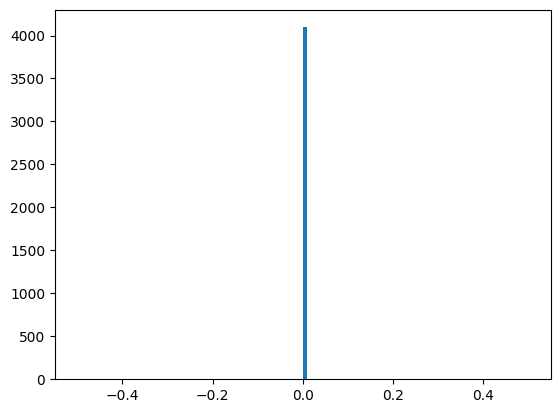

In [13]:
h=plt.hist((y1-y2).flatten(),bins=100)

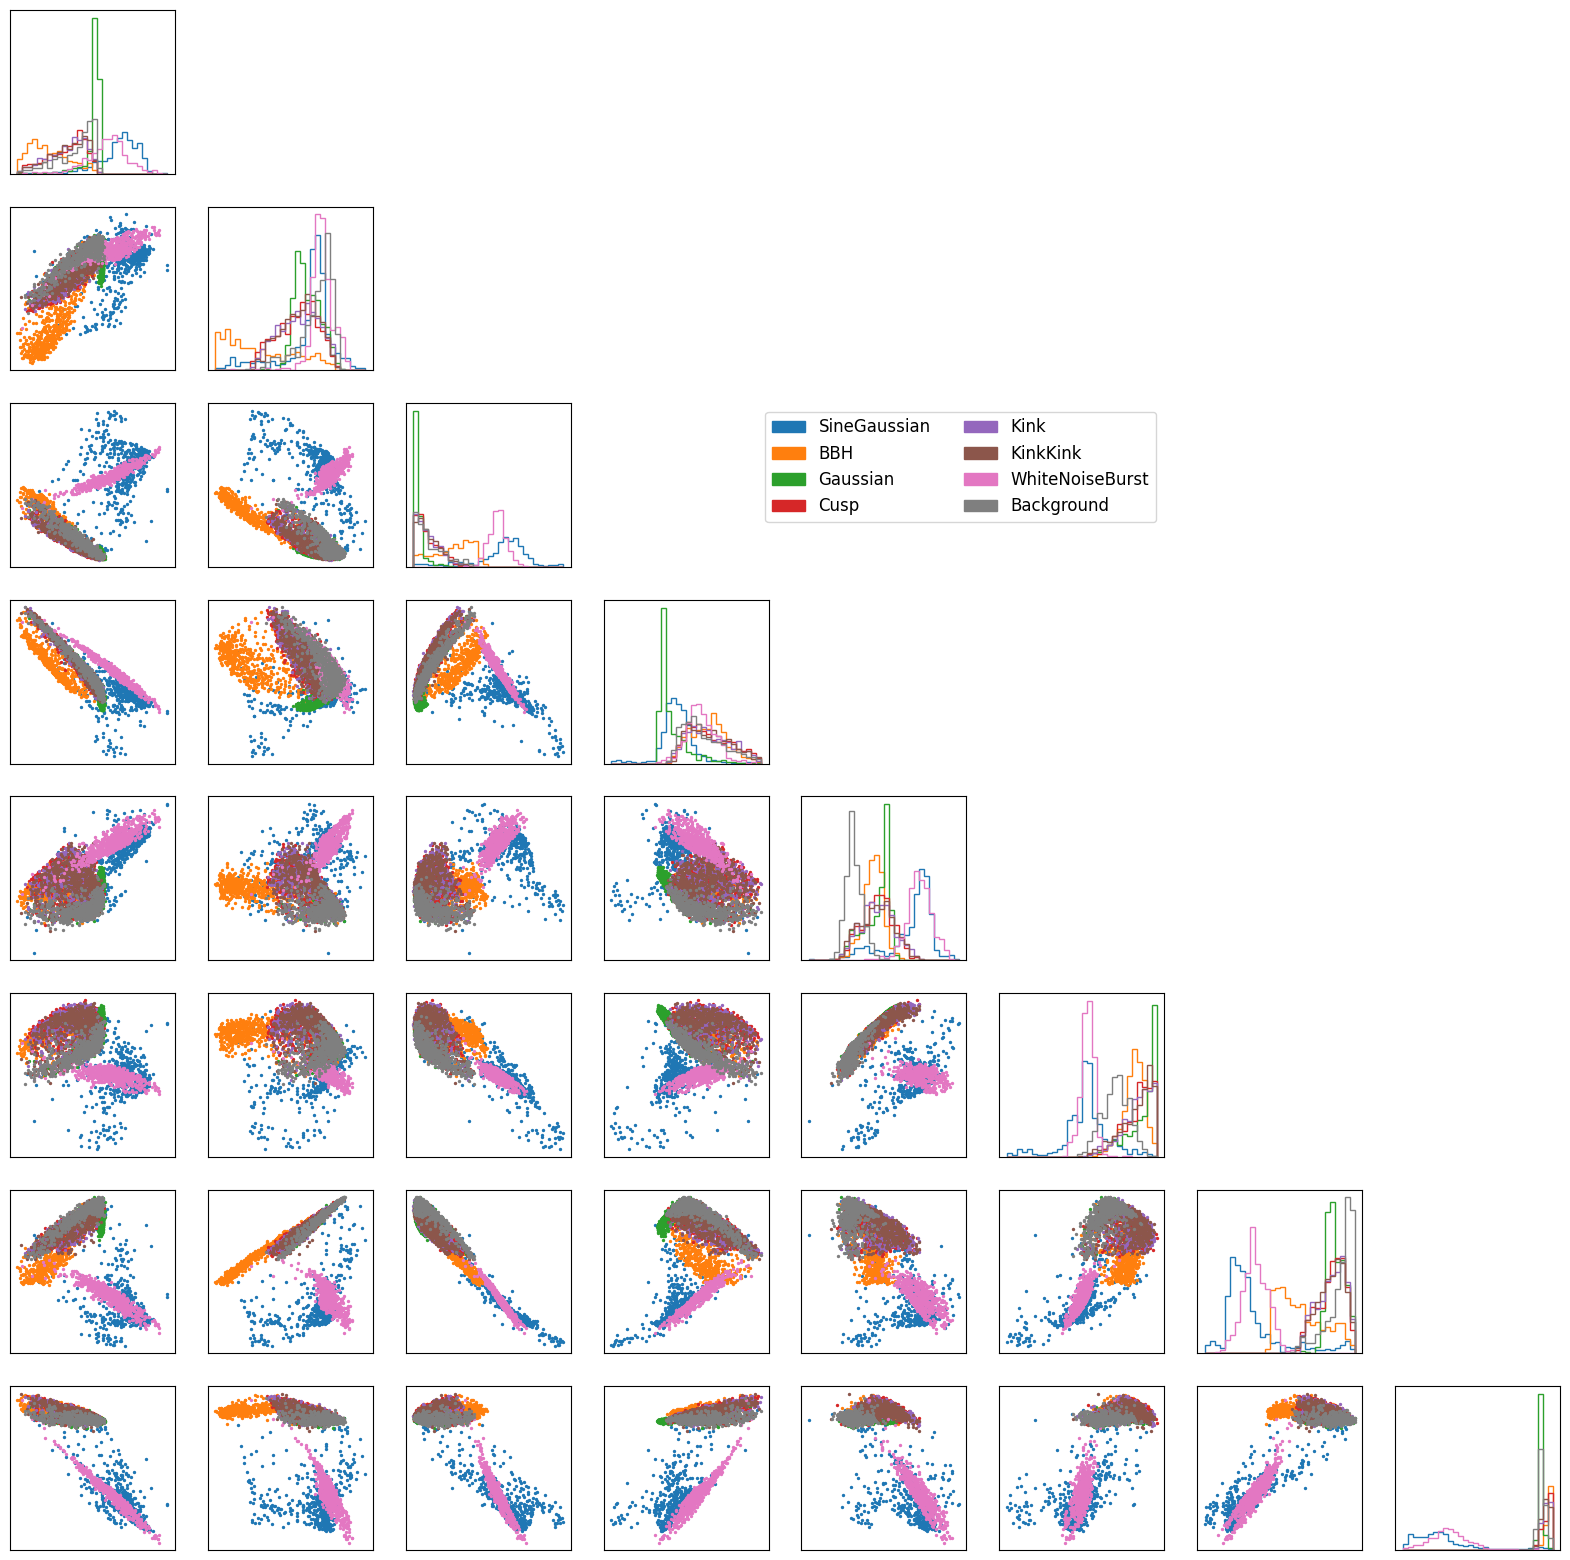

In [14]:
#import corner

N = y.shape[1]
labs_uniq = sorted(list(set(l)))
fig,axes = plt.subplots(N,N,figsize=(20,20))

for i in range(y.shape[1]):
    for j in range(i+1,y.shape[1]):
        plt.sca(axes[i,j])
        plt.axis('off')

for i in range(y.shape[1]):
    plt.sca(axes[i,i])
    plt.xticks([])
    plt.yticks([])
    bins = 30
    for j,lab in enumerate(labs_uniq):
        h,bins,_ = plt.hist(y[l==lab][:,i],bins=bins,histtype='step',color=f"C{j}")
        
for i in range(1,y.shape[1]):
    for j in range(i):
        plt.sca(axes[i,j])
        plt.xticks([])
        plt.yticks([])
        for k,lab in enumerate(labs_uniq):
            ysel = y[l==lab]
            plt.scatter(ysel[:,j],ysel[:,i],s=2,color=f"C{k}")
            
from matplotlib.patches import Patch
plt.sca(axes[2,5])
patches = []
for k,lab in enumerate(labs_uniq):
    patches.append(Patch(color=f"C{k}",label=signal_classes[k]))
plt.legend(handles=patches,ncol=2,fontsize=12)

#plt.tight_layout()

plt.savefig("test.png")
#for i,lab in enumerate(sorted(list(set(l)))):
#    corner.corner(y[l==lab],fig=fig,color=f"C{i}")